In [22]:
import os
import sys
import warnings
import iris.plot as iplt
import glob as glob
warnings.simplefilter(action = 'ignore', category = FutureWarning)
import matplotlib.path as mpltPath
import pyproj
from pyproj import CRS
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon, MultiPolygon
import iris 
import matplotlib.pyplot as plt
import numpy as np

# Set up path to root directory
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

def create_gb_outline (required_proj):
    '''
    Description
    ----------
        Creates a shapely geometry of the outline of the UK in the projection specified
        Involves joining a gdf of UK with one of Ireland
        
    Parameters
    ----------
        required_proj : Dict
            Python dictionary with a key init that has a value epsg:4326. 
            This is a very typical way how CRS is stored in GeoDataFrames 
            e.g. {'init' :'epsg:3785'} for Web Mercator
            or   {'init' :'epsg:4326'} for WGS84

    Returns
    -------
        uk_gdf : Geodataframe
            Dataframe contaiing coordinates of outline of UK region
    
    '''
    # Read in outline of UK
    uk_regions = gpd.read_file("/nfs/a319/gy17m2a/PhD/datadir/SpatialData/UK_shp/GBR_adm1.shp") 
    uk_regions= uk_regions[uk_regions['NAME_1'] !='Northern Ireland'] 
    uk_regions = uk_regions.to_crs({'init' :'epsg:27700'}) 
    uk_regions = uk_regions[['geometry']]

    # Convert to required projection
    uk_regions = uk_regions.to_crs(required_proj) 

    merged_geometry = uk_regions.geometry.unary_union

    # Convert the merged geometry into a single Polygon
    if merged_geometry.geom_type == 'MultiPolygon':
        # If the merged geometry is a MultiPolygon, you can take its convex hull
        # or apply any other method to convert it into a single Polygon.
        single_polygon = merged_geometry.convex_hull
    elif merged_geometry.geom_type == 'Polygon':
        # If the merged geometry is already a Polygon, you can directly use it.
        single_polygon = merged_geometry
    else:
        # Handle other cases if necessary
        single_polygon = None
    merged_geometry

    # Create a DataFrame with a single row containing the merged geometry
    data = {'geometry': [merged_geometry]}
    merged_gdf = gpd.GeoDataFrame(data, crs=uk_regions.crs)
    
    return merged_gdf

def create_uk_outline (required_proj):
    '''
    Description
    ----------
        Creates a shapely geometry of the outline of the UK in the projection specified
        Involves joining a gdf of UK with one of Ireland
        
    Parameters
    ----------
        required_proj : Dict
            Python dictionary with a key init that has a value epsg:4326. 
            This is a very typical way how CRS is stored in GeoDataFrames 
            e.g. {'init' :'epsg:3785'} for Web Mercator
            or   {'init' :'epsg:4326'} for WGS84

    Returns
    -------
        uk_gdf : Geodataframe
            Dataframe contaiing coordinates of outline of UK region
    
    '''
    # Read in outline of UK
    uk_regions = gpd.read_file("/nfs/a319/gy17m2a/PhD/datadir/SpatialData/UK_shp/GBR_adm1.shp") 
    uk_regions = uk_regions.to_crs({'init' :'epsg:27700'}) 
    uk_regions = uk_regions[['geometry']]

    roi_regions = gpd.read_file("/nfs/a319/gy17m2a/PhD/datadir/SpatialData/IRL_adm/IRL_adm1.shp") 
    roi_regions = roi_regions.to_crs({'init' :'epsg:27700'}) 
    roi_regions = roi_regions[['geometry']] 

    # # Join the two
    uk_gdf = pd.concat([uk_regions, roi_regions])
    uk_gdf['merging_col'] = 0
    uk_gdf = uk_gdf.dissolve(by='merging_col')

    # Convert to required projection
    uk_gdf = uk_gdf.to_crs(required_proj) 

    return uk_gdf

# Don't really understand why we need this
def explode_polygon(indata):
    indf = indata
    outdf = gpd.GeoDataFrame(columns=indf.columns)
    for idx, row in indf.iterrows():
        if type(row.geometry) == Polygon:
            #note: now redundant, but function originally worked on
            #a shapefile which could have combinations of individual polygons
            #and MultiPolygons
            outdf = outdf.append(row,ignore_index=True)
        if type(row.geometry) == MultiPolygon:
            multdf = gpd.GeoDataFrame(columns=indf.columns)
            recs = len(row.geometry)
            multdf = multdf.append([row]*recs,ignore_index=True)
            for geom in range(recs):
                multdf.loc[geom,'geometry'] = row.geometry[geom]
            outdf = outdf.append(multdf,ignore_index=True)
    return outdf

In [8]:
# Load necessary spatial data
# This is a square area surrounding Leeds
gb_gdf = create_gb_outline({'init' :'epsg:4326'})
uk_gdf = create_uk_outline({'init' :'epsg:4326'})

In [11]:
# Explode the BritishColumbia MultiPolygon into its constituents
gb_gdf_exploded=explode_polygon(gb_gdf)
uk_gdf_exploded=explode_polygon(uk_gdf)

## Create 5km mask
### Load example data

In [14]:
filename ='/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/pr_rcp85_land-cpm_uk_5km_01_1hr_19810101-19810130.nc'

monthly_cubes_list = iris.load(filename)
cube = monthly_cubes_list[0]
cube_onets = cube[0,0,:,:]

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


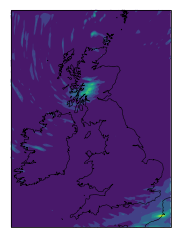

In [17]:
iplt.contourf(cube_onets)
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [ ]:
# cube_onets = trim_to_bbox_of_region_obs(cube_onets, gb_gdf, 'projection_y_coordinate', 'projection_x_coordinate')

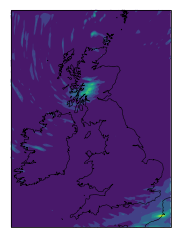

In [18]:
iplt.contourf(cube_onets)
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [19]:
#FIRST, read in the target data and latitude-longitude grid from netcdf file
lat1d=cube_onets.coord('projection_y_coordinate').points
lon1d = cube_onets.coord('projection_x_coordinate').points

In [23]:
# Step 3: Create meshgrid of latitude and longitude coordinates
lon2d, lat2d = np.meshgrid(lon1d, lat1d)

In [24]:
bng_crs = CRS.from_epsg(27700)
wgs84_crs = CRS.from_epsg(4326)
transformer = pyproj.Transformer.from_crs(bng_crs, wgs84_crs)

# List to store points
points=[]

for latit in range(0,lat2d.shape[0]):
    for lonit in range(0,lon2d.shape[1]):
        lon1d_wgs84, lat1d_wgs84 = transformer.transform(lon2d[latit,lonit], lat2d[latit,lonit])
        point=(lat1d_wgs84, lon1d_wgs84)
        points.append(point)

#turn into np array for later
points=np.array(points)

#get the cube data - useful for later
fld=np.squeeze(cube_onets.data)

#create a mask array of zeros, same shape as fld, to be modified by
#the code below
mask=np.zeros_like(fld)

In [25]:
#Loop over each individual polygon and get external coordinates
for index,row in uk_gdf_exploded.iterrows():

    # print ('working on polygon', index)
    mypolygon=[]
    for pt in list(row['geometry'].exterior.coords):
        # print (index,', ',pt)
        mypolygon.append(pt)

    #See if any of the original grid points read from the netcdf file earlier
    #lie within the exterior coordinates of this polygon
    #pth.contains_points returns a boolean array (true/false), in the
    #shape of 'points'
    path=mpltPath.Path(mypolygon)
    inside=path.contains_points(points)

    #find the results in the array that were inside the polygon ('True')
    #and set them to missing. First, must reshape the result of the search
    #('points') so that it matches the mask & original data
    #reshape the result to the main grid array
    inside=np.array(inside).reshape(lon2d.shape)
    i=np.where(inside == True)
    mask[i]=1

### Check if it worked

In [26]:
# Get list of indices that should be masked out
i=np.where(mask == 0)

cube = monthly_cubes_list[0]
cube_onets = cube[0,0,:,:]
# cube_onets = trim_to_bbox_of_region_obs(cube_onets, gb_gdf)

# Give these points a np.nan in the cube data
cube_onets.data[i]=np.nan

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


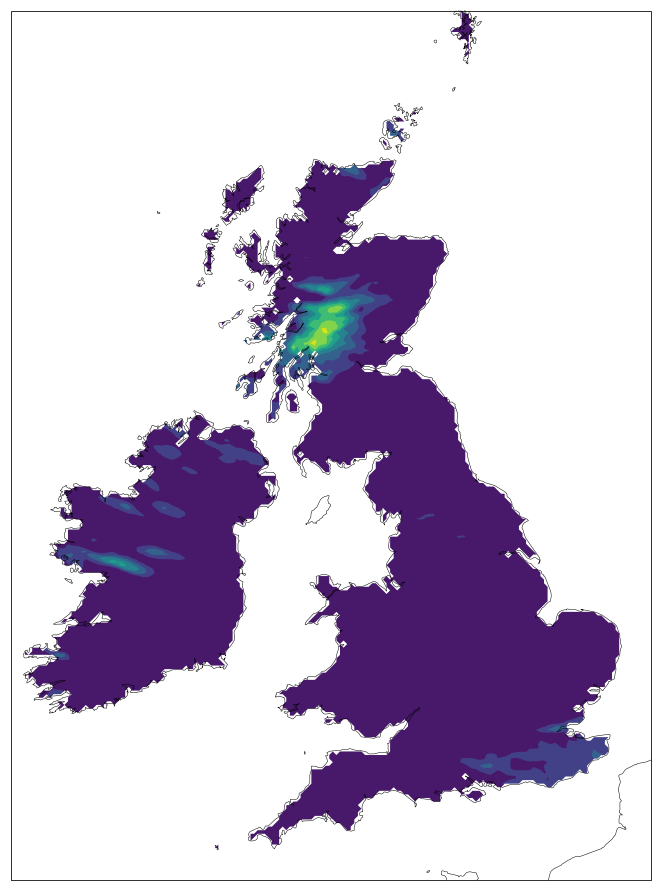

In [27]:
plt.figure(figsize=(20, 16))  # Adjust width and height as needed

# Plot contourf with Iris
iplt.contourf(cube_onets)
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

### Save

In [ ]:
np.save('/nfs/a319/gy17m2a/PhD/datadir/UKCP18_5km_UK_Mask.npy', mask.data)